In the "fitting.ipynb" notebook, we specified a desired fit tolerance and the fit would keep adding basis functions until it achieved the given fit tolerance. If the data has a noise level and we specify the noise level as the fit tolerance, we obtain good results.

Unfortunately, we may not know how noisy our data is. For this we can use a cross-validation study:

(To estimate the out-of-sample er- rors of the surrogate model, we perform a 20-fold cross- validation test. This is done by first randomly dividing the 886 NR waveforms into 20 sets of 44 or 45 waveforms. For each set, we build a trial surrogate using the wave- forms from the other 19 sets. The trial surrogate is then evaluated at the parameters corresponding to the wave- forms in the chosen validation set, and the results are compared to the NR waveform. From Scott Fields paper)

    * Divide the data into a training set and a validation set
    * Perform the fit using only the training set, continuing well beyond the expected optimal number of coefficients
    * At each number of coefficients, compute the fit error for the validation set
    * Choose the number of coefficients to minimize the largest validation error

We typically do not know how to divide the data into training and validation sets in a good way.
If we choose randomly, we could:

    * Put a crucial data point in the validation set, causing the fits to be poor
    * Put a data point with very large error in the validation set, causing all validation errors to be large

To overcome these potential issues, we perform the study many times. With a small validation set size compared to the number of data points, we should then encounter one of these issues in only a small percentage of the different studies. Since there will still be some bad results, for each number of coefficients we take the root-mean-square of the *largest* validation error over all studies, and use the number of coefficients that minimizes this error.

Now that we have the desired number of coefficients, we perform a final fit using all the data.

**Note**: Unlike the other notebooks, there are no regression tests for this notebook. The reason is that the key pySur routines used here (fit_greedy, fit, and FittedFunction) are used used in fitting.ipynb, GPR_fitting.ipynb, and fit_3d_spherical.ipynb, which already have regression testing.

In [4]:
import pySurrogate as pySur
import numpy as np
fit = pySur.fit
fit_greedy = pySur.fit_greedy
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('always')

In [5]:
# Exact solution
def f(x):
    return np.sin(x)

# The data can be noisy
noise_level = 0.1
def apply_noise(data):
    return data + noise_level*(np.random.random(np.shape(data)) - 0.5)

# Choose some data points - let's fit between 0 and 5:
xMin = 0.
xMax = 5.
nPts = 10
xVals = np.linspace(xMin, xMax, nPts)
yVals = apply_noise(f(xVals))

# Setup a function modeler
ff = pySur.FittedFunction('1d-polynomial-fitter')
for x, y in zip(xVals, yVals):
    ff.addKnownDataSet(np.array([x]), y)

# We use different settings for a cross-validation fit
print( "default fit values: ")
print( fit_greedy.CV_DEFAULTS)

default fit values: 
{'fitType': 'Greedy', 'bfTypes': 'chebyshev', 'bfMaxOrders': 'fromData', 'minVals': 0.0, 'maxVals': 1.0, 'rmsCutoff': 'crossValidation', 'maxCoefConst': 'nPoints', 'cv_N': '10percent', 'cv_nTrials': 1, 'cv_crucial_indices': []}


1d-polynomial-fitter results: 8 coefs, 0.00470531991175116 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 8 coefs, 0.003298124404962688 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 6 coefs, 0.020264826215930842 rms max test error, 0.03453738288368493 max residual
1d-polynomial-fitter results: 8 coefs, 0.00470531991175116 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 8 coefs, 0.003298124404962688 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 6 coefs, 0.020264826215930842 rms max test error, 0.03453738288368493 max residual
1d-polynomial-fitter results: 2 coefs, 0.013754854898105906 rms max test error, 0.43140397773579753 max residual
1d-polynomial-fitter results: 5 coefs, 0.0007364842009749406 rms max test error, 0.04796589823056314 max residual
1d-polynomial-fitter results: 8 coefs, 0.00470531991175116 rms max test error, 0.0157371240502564

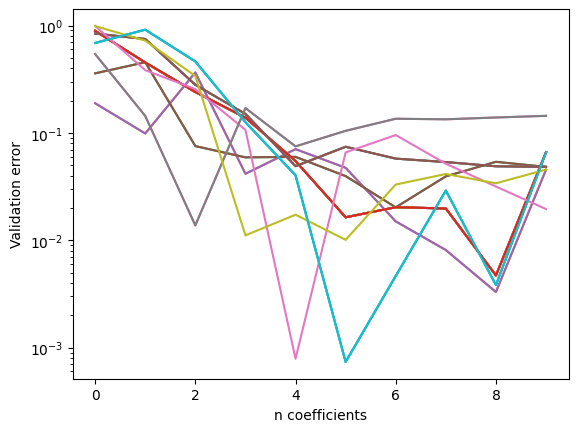

In [20]:
# Let's try only doing 1 trial, using 1 validation point.
# We can repeat it many times to see if it's consistent
ff.setupFits(minVals=xMin, maxVals=xMax, rmsCutoff='crossValidation', cv_N=1, cv_nTrials=1)

for i in range(20):
    ff.fit()
    plt.semilogy(ff.fitResults['rmsMaxLSOResids'])

plt.xlabel("n coefficients")
plt.ylabel("Validation error")
plt.show()

Wow, those results are really inconsistent!

The final number of coefficients used is the minimum of whichever particular curve happened, which seems like it could be anything!
What's likely happening with the curves that have large errors for all number of coefficients is that the validation point is on the edge of the domain, meaining the trial fit using the training data is extrapolating!
Let's try excluding those boundary points from being validation points.

1d-polynomial-fitter results: 2 coefs, 0.013754854898105906 rms max test error, 0.43140397773579753 max residual
1d-polynomial-fitter results: 8 coefs, 0.003298124404962688 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 5 coefs, 0.010096546472173729 rms max test error, 0.04796589823056314 max residual
1d-polynomial-fitter results: 4 coefs, 0.0007886488813090287 rms max test error, 0.05245558039701301 max residual
1d-polynomial-fitter results: 8 coefs, 0.00470531991175116 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 8 coefs, 0.00470531991175116 rms max test error, 0.01573712405025645 max residual
1d-polynomial-fitter results: 6 coefs, 0.020264826215930842 rms max test error, 0.03453738288368493 max residual
1d-polynomial-fitter results: 9 coefs, 0.04827309844090932 rms max test error, 0.00900310616392994 max residual
1d-polynomial-fitter results: 2 coefs, 0.013754854898105906 rms max test error, 0.4314039777357975

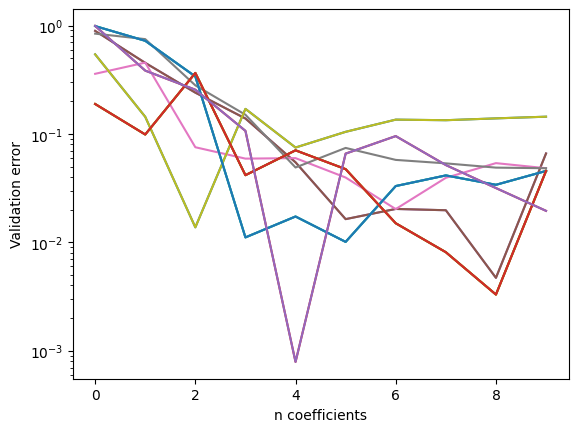

In [26]:
ff.setupFits(minVals=xMin, maxVals=xMax, rmsCutoff='crossValidation',
             cv_N=1, cv_nTrials=1, cv_crucial_indices = [0, len(xVals)-1])

for i in range(15):
    ff.fit()
    plt.semilogy(ff.fitResults['rmsMaxLSOResids'])

plt.xlabel("n coefficients")
plt.ylabel("Validation error")
plt.show()

That's definitely a little better, but it's still very inconsistent.
That's because the quality of the fit still depends on which point is left out!
We did 20 trials but there are 8 curves here: 10 data points minus the two boundary points.
What happens when we average over them?

1d-polynomial-fitter results: 4 coefs, 0.05398863779504809 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.051600133781607625 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.053741472932144006 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.05021144166189677 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.04786252868920612 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.05500305917564976 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.052260638511040715 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 4 coefs, 0.050358235549089504 rms max test error, 0.05245558039701301 max residual
4
1d-polynomial-fitter results: 5 coefs, 0.05088466647012355 rms max test error, 0.047

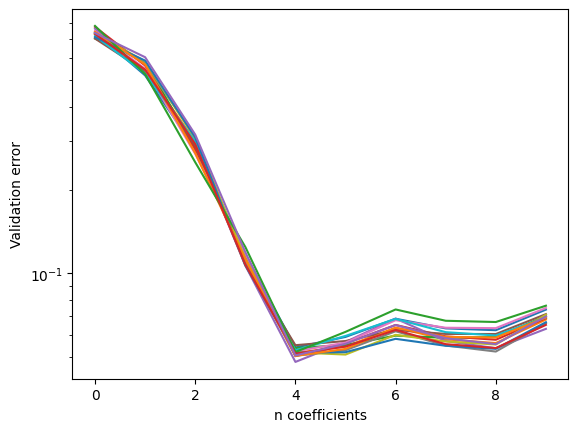

In [25]:
ff.setupFits(minVals=xMin, maxVals=xMax, rmsCutoff='crossValidation', cv_N=1, cv_nTrials=50)

for i in range(15):
    ff.fit()
    plt.semilogy(ff.fitResults['rmsMaxLSOResids'])
    print(len(ff.fitResults['coefs']))

plt.xlabel("n coefficients")
plt.ylabel("Validation error")
plt.show()



That's much better!
I ended up with 6 coefficients one time and 7 coefficients 4 times.
Note that we didn't have to do anything about the boundary indices, because the RMS average does a good enough job.

Of course, since we're using random validation sets we can always do better with more trials!

1d-polynomial-fitter results: 5 coefs, 0.037611375139752115 rms max test error, 0.051401986605048425 max residual
5
1d-polynomial-fitter results: 5 coefs, 0.03593196135297473 rms max test error, 0.051401986605048425 max residual
5
1d-polynomial-fitter results: 5 coefs, 0.03951050927793606 rms max test error, 0.051401986605048425 max residual
5
1d-polynomial-fitter results: 5 coefs, 0.03482269792252278 rms max test error, 0.051401986605048425 max residual
5
1d-polynomial-fitter results: 5 coefs, 0.036011167444341186 rms max test error, 0.051401986605048425 max residual
5


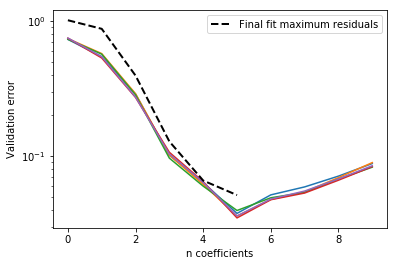

In [9]:
ff.setupFits(minVals=xMin, maxVals=xMax, rmsCutoff='crossValidation', cv_N=1, cv_nTrials=200)

for i in range(5):
    ff.fit()
    plt.semilogy(ff.fitResults['rmsMaxLSOResids'])
    print len(ff.fitResults['coefs'])

plt.semilogy(ff.fitResults['maxResids'], 'k--', lw=2., label="Final fit maximum residuals")

plt.xlabel("n coefficients")
plt.ylabel("Validation error")
plt.legend(loc='upper right')
plt.show()
